In [30]:
#import modules
import xarray as xr
import numpy as np
import pandas as pd
import salem
import plotly.graph_objects as go

import sys
sys.path.append('/exports/csce/datastore/geos/users/s1878599/python_code/')
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st, IGP as igp

import warnings
warnings.filterwarnings('ignore')

#for getting only pib data
import salem
shdf= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/IGP.shp")

## Create functions for calculating emissions 

In [31]:
# CREATE FUNCTIONS FO FIRE EMISSIONS CALCULATION.

def emi_unirates_fire(ds): 
    "uniforms all emissions rates from [mol km-2 hr-1] to [ug m-2 s-1]"

    #NOTE non obvious conversions (based on the fire_map in fire-emis utility): open->BIGALD;acetol -> HYAC, apin->CH10H16
    molw ={ "co":28, "no":30,"no2":46,"so2":64,"bigalk":72,"bigene":56, "c2h4":28, "c2h5oh":46, "c2h6":30, "c3h8":44, "c3h6":42, 
            "ch2o":30, "ch3cho":44, "ch3coch3":58, "ch3oh":32, "mek":72, "toluene":92, "nh3":17,"open":98, "c10h16":136, 
           "ch3cooh":60, "cres":108, "glyald":60, "mgly":72, "acetol":74, "isop":68, "macr":70, 
            "mvk":70, "gly":72}
    gug=1e+6 #g to ug.
    km2m2=1e+6 # km2 to m2.
    hrsec=3600 #hour to sec 
    conv = gug/(km2m2*hrsec)   # ug m-2 s-1
    dsc=ds.copy(deep=True)
    for sp in molw.keys():
        dsc["ebu_in_"+ sp]= dsc["ebu_in_"+ sp]*molw[sp]*conv  
        dsc["ebu_in_"+ sp].attrs["units"]="ug m-2 s-1"

    return dsc

def calc_emifire(ds,sres):
    """
    Convert wrffirechemi emissions rates to hourly emissions at each grid point [ug m-2 hour-1].
    """
    km2m2=1e+6 # km2 to m2. sres in km need to convert in m
    hrsec=3600 #hour to sec
    ugTg=1e-18 #ug to Tg
       
    ds["tot_emi"]= xr.DataArray(np.zeros(ds["ebu_in_co"].shape), coords=ds.coords, dims=ds.dims)
   
    for da in ds.data_vars.values():
        if da.name.startswith("ebu_in"):
            ds[da.name]=ds[da.name]*hrsec*km2m2*(sres*sres)*ugTg   #  emissions at each gridpoint at each hour.
            ds[da.name].attrs["units"]="Tg hour-1"
            
            ds["tot_emi"]=ds["tot_emi"]+ds[da.name]  #adding to total emissions.
            
    ds["tot_emi"].attrs["units"]="Tg hour-1"
   

In [32]:
def add_lat_lon_fire(dsf):
    #Adding XLAT and XLONG to fire emissions dataset
    datapath ='/geos/d21/s1878599/IGP/outputs/autumn/wrfout_d01_2017-10-18_00:00:00_.nc'
    ds = xr.open_dataset(datapath)
    #reshaping XLAT and LONG to ds_fire sizes.
    lat =np.resize(ds.XLAT.values,dsf.ebu_in_co.shape)
    long =np.resize(ds.XLONG.values,dsf.ebu_in_co.shape)

    #adding to ds_fire
    dsf['XLAT'] = xr.DataArray(lat, dims = dsf.dims)
    dsf['XLONG'] = xr.DataArray(long, dims = dsf.dims)

## Prepare emissions difference

In [33]:
#GET FIRE EMISSIONS DATA for perturbation period.

fab_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_autumn/emi_base/wrffirechemi_d01_2017*'
fap_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_autumn/emi_ptrb/wrffirechemi_d01_2017*'
fwb_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_winter/emi_base/wrffirechemi*'
fwp_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_winter/emi_ptrb/wrffire*'
fpmb_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_premonsoon/emi_base/wrffire*'
fpmp_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_premonsoon/emi_ptrb/wrffire*'
fmb_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_monsoon/emi_base/wrffire*'
fmp_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_monsoon/emi_ptrb/wrffire*'

fap = xr.open_mfdataset(fap_pth, concat_dim='Time').sel(Time=slice(504,552))
fab = xr.open_mfdataset(fab_pth, concat_dim='Time').sel(Time=slice(504,552)) # 48h
fwb = xr.open_mfdataset(fwb_pth, concat_dim='Time').sel(Time=slice(504,552)) 
fwp  =xr.open_mfdataset(fwp_pth,concat_dim='Time').sel(Time=slice(504,552))
fpmb = xr.open_mfdataset(fpmb_pth, concat_dim='Time').sel(Time=slice(504,552)) 
fpmp = xr.open_mfdataset(fpmp_pth,concat_dim='Time').sel(Time=slice(504,552)) 
fmb = xr.open_mfdataset(fmb_pth , concat_dim='Time').sel(Time=slice(504,552)) 
fmp = xr.open_mfdataset(fmp_pth ,concat_dim='Time').sel(Time=slice(504,552)) 

In [34]:
# put everything in a dict by season
emi_f={"aut":[fab,fap], "win":[fwb,fwp],"pmon":[fpmb,fpmp],"mon":[fmb,fmp]}

In [35]:
#Calculate total hourly emissions at each gridpoint [ug hour-1] 
for v in emi_f.values():
    for ds in v: 
        temp=emi_unirates_fire(ds)
        calc_emifire(temp,sres=20)
        ds["tot_emi"]=temp.tot_emi

In [36]:
u= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/U_IGP.shp")
m= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/M_IGP.shp")
l= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/L_IGP.shp")
shp={'upp':u,'mid':m,'low':l}

In [37]:
emi={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
for s in emi_f.keys():
    for k in shp.keys():
        add_lat_lon_fire(emi_f[s][0])
        add_lat_lon_fire(emi_f[s][1])
        v0igp=emi_f[s][0].salem.roi(shape=shp[k])
        v1igp=emi_f[s][1].salem.roi(shape=shp[k])
        tb= (v0igp['tot_emi'].sum(dim=['Time', 'emissions_zdim_stag','south_north','west_east'])).values
        tp= (v1igp['tot_emi'].sum(dim=['Time', 'emissions_zdim_stag','south_north','west_east'])).values
        d=tp-tb # difference Tg
        emi[s].update({k:d})

In [38]:
emi['aut']

{'upp': 0.0022634261540616374,
 'mid': 0.0008249837505474485,
 'low': 5.964416109296988e-06}

In [39]:
emi['mon']

{'upp': 2.005051025725862e-05,
 'mid': 4.76063467171918e-06,
 'low': 1.897708646573376e-05}

In [40]:
# create masks
def create_masks(ds,shp,emi):
    masks={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
    for s in emi.keys():
        for k in shp.keys():
            ds.PM2_5_DRY.values=(emi[s][k])*np.ones(ds.PM2_5_DRY.shape) 
            t=ds.salem.roi(shape=shp[k])  
            np.nan_to_num(t.PM2_5_DRY.values, copy=False, nan=1, posinf=0.0, neginf=0.0)
            m=t.PM2_5_DRY[0,0,:,:]
            masks[s].update({k:m})
    return masks 

In [41]:
ds= xr.open_mfdataset('/geos/d21/s1878599/IGP/outputs/autumn/wrfout_d01_2017-11-01_00:00:00_.nc')
emimsk=create_masks(ds,shp,emi)

## Prepare aerosols outputs

In [42]:
# get aerosol data ALL DOMAIN
oab_pth='/geos/d21/s1878599/IGP/outputs/autumn/wrfout_d01_2017-11-01_00:00:00_.nc'
oap_pth='/geos/d21/s1878599/wrfout_d01_2017-11-01_00:00:00_fp2.nc'
owb_pth='/geos/d21/s1878599/IGP/outputs/winter/wrfout_d01_2018-01-22_00:00:00_.nc'
owp_pth='/geos/d21/s1878599/wrfout_d01_2018-01-22_00:00:00_fp2.nc'
opmb_pth='/geos/d21/s1878599/IGP/outputs/premonsoon/wrfout_d01_2017-05-02_00:00:00.nc'
opmp_pth='/geos/d21/s1878599/wrfout_d01_2017-05-02_00:00:00_pf2.nc'
omb_pth='/geos/d21/s1878599/IGP/outputs/monsoon/wrfout_d01_2017-07-17_00:00:00_.nc'
omp_pth='/geos/d21/s1878599/wrfout_d01_2017-07-17_00:00:00_fp2.nc'

oab= xr.open_mfdataset(oab_pth).sel(Time=slice(1,16)) # get period from 1 nov to 8 nov without 
oap=xr.open_mfdataset(oap_pth).sel(Time=slice(1,16))  # output perturbed from antrho
owb= xr.open_mfdataset(owb_pth).sel(Time=slice(1,16)) # et period from 22 jan to 29 nov
owp=xr.open_mfdataset(owp_pth).sel(Time=slice(1,16))  # output perturbed from antrho
opmb= xr.open_mfdataset(opmb_pth).sel(Time=slice(1,16)) # get period from 2 may to 8 may
opmp=xr.open_mfdataset(opmp_pth).sel(Time=slice(1,16))  # output perturbed from antrho
omb=xr.open_mfdataset(omb_pth).sel(Time=slice(1,16)) # get period from 17 july to 24 july
omp=xr.open_mfdataset(omp_pth).sel(Time=slice(1,16)) # output perturbed from fire

In [43]:
# put everything in a dict by season
sfout={"aut":[oab,oap], "win":[owb,owp],"pmon":[opmb,opmp],"mon":[omb,omp]}

In [44]:
#get aerosols for each dataset
aaer={}
for k,v in sfout.items():
    
    baer= aer.get_aerosols(v[0])
    baer.attrs=v[0].attrs
    paer= aer.get_aerosols(v[1])
    paer.attrs=v[1].attrs
    
    aaer.update({k :[baer,paer]})   

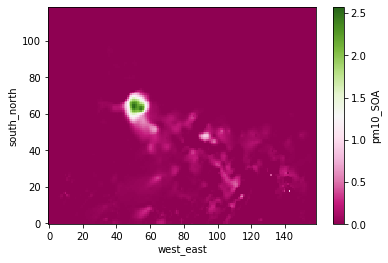

In [45]:
(aaer['aut'][1].pm10_SOA.sum("Time")- aaer['aut'][0].pm10_SOA.sum("Time")).clip(min=0)[0,:,:].plot(cmap='PiYG')

## Calculate sensitivities

In [46]:
#Create function for surface sensitivity at gridpoint ij for a specified species.

def get_s_ij(bds,pds,delta_emi,var):
    """
    bds = base output
    pds = perturbed output
    delta_emi = total difference in emissions [ug/m3]
    var = variable for which calculate sensitivity.
    """
    # surface total difference in concentration over sim period [ug/m3]
    diff_var = (pds[var]-bds[var]).sum('Time')[0, :, :]
    diff_var = diff_var.clip(min=0.0)
    np.nan_to_num(diff_var, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    s = (diff_var/delta_emi['upp']/delta_emi['mid']/delta_emi['low']) #divide by local emissions
    return xr.Dataset({"sty":s},coords=dict(delta_emi['upp'].coords))

# calculate sensitivities for all season and put in a dict
def sensitivity(do,de,var):
    "do= output dict,de=emissions dict var=varname "
    shdfigp= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/IGP.shp")
    s={}
    for k in do.keys():
        
        sens= get_s_ij(do[k][0],do[k][1],de[k],var) # calc sensitivity
        sens.attrs=do[k][0].attrs 
        sens_igp = sens.salem.roi(shape=shdfigp)  # get sensitivity only for IGP
        s.update({k:[sens_igp,sens]})

    return s

In [47]:
# calculate sensitivities for PM2.5
spm25=sensitivity(aaer,emimsk,"pm25_tot")

In [48]:
# calculate sensitivities for POA
sPOA=sensitivity(aaer,emimsk,"pm10_POA")

In [49]:
# calculate sensitivities for SOA
sSOA=sensitivity(aaer,emimsk,"pm10_SOA")

In [50]:
# calculate sensitivities for OA
sOA=sensitivity(aaer,emimsk,"pm10_OA")

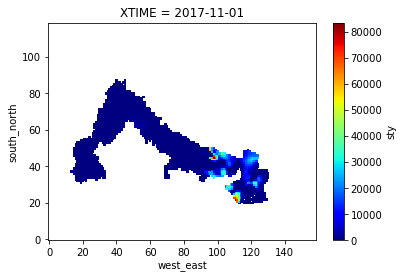

In [51]:
sSOA["aut"][0].sty.plot(cmap='jet')

## PLOTS

In [52]:
#SPATIAL PLOT IGP

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

def set_formatter(axes):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
        gl.ylocator = mticker.FixedLocator([20,25,30,35])
        
        ax.add_feature(cfeature.COASTLINE, lw=0.5)
        ax.add_feature(cfeature.BORDERS, lw=0.5)
        
    # get lon values only n the last ax
        if ax==axes[3]:
            gl.xlabels_bottom = True
    
    
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=1, lw=0.5)
            


def sensplot(lat,lon,pmds,mds,ads,wds,vmin=0,vmax=None, title=None, label=None, cmap="OrRd",levs=10, 
            figsize=[7, 10],format="%.2f",save=False,spath=None,name="plot",savef='pdf', dpi=100):

    fig, axes =plt.subplots(nrows=4,ncols=1,figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    igp_shp="/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/IGP.shp"
    shp_path=(igp_shp,igp_shp,igp_shp,igp_shp)
    
    set_formatter(axes.flatten())
    set_admin(axes.flatten(), shp_path)
 
    #Getting values.
    
    vpm=pmds[:,:].values #.clip(min=0)
    #np.nan_to_num(vpm, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    vm= mds[:,:].values #.clip(min=0)
    #np.nan_to_num(vm, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    va= ads[:,:].values #.clip(min=0)
    #np.nan_to_num(va, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    vw= wds[:,:].values #.clip(min=0)
    #np.nan_to_num(vw, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
   
    import math
    if vmax is None:  # Get the max value in the array to plot.
        vmax =np.array([np.nanmax(vpm),np.nanmax(vm),np.nanmax(va),np.nanmax(vw)]).max() 
      
    print(vmin,vmax)
    levels = np.linspace(vmin, vmax, levs)  # number of levels for which divide the bar. Customise 
    print(levels)
    
    # premonsoon
    cspm=axes[0].contourf(lon,lat,vpm,transform=ccrs.PlateCarree(),cmap=cmap, vmin=vmin,vmax=vmax,levels=levels,
                            extend="both")#,locator=mticker.LogLocator())
    cspm.cmap.set_over("#800000")
    cspm.cmap.set_under("#000080")
                                                 
    # monsoon
    csm=axes[1].contourf(lon,lat,vm,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=levels,
                          extend="both")#,locator=mticker.LogLocator()) 
    csm.cmap.set_over("#800000")
    csm.cmap.set_under('#000080')   #("#FFFFFF")
    #autumn
    csa=axes[2].contourf(lon,lat,va,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=levels,
                          extend="both")#,locator=mticker.LogLocator()) 
    csa.cmap.set_over("#800000")
    csa.cmap.set_under("#000080")
    #winter
    csw=axes[3].contourf(lon,lat,vw,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=levels,
                          extend="both")#,locator=mticker.LogLocator()) 
    csw.cmap.set_over("#800000")
    csw.cmap.set_under("#000080")
    
 
    axes[0].text(-0.15, 0.55, 'PRE-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[0].transAxes)
    axes[1].text(-0.15, 0.55, 'MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[1].transAxes)
    axes[2].text(-0.15, 0.55, 'POST-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[2].transAxes)
    axes[3].text(-0.15, 0.55, 'WINTER', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[3].transAxes)
    
    fig.subplots_adjust(right=0.8,hspace=0.4)  
    cbar_ax = fig.add_axes([0.85, 0.1, 0.05, 0.8])  #[left, bottom, width, height]
    cbar= fig.colorbar(csw, cax=cbar_ax,pad=0.35,shrink=1, format=format)
    cbar.set_label(label,fontsize=13)
    cbar.ax.tick_params(labelsize='medium')

    if title is not None:
        axes[0].set_title(title, fontsize=12,pad=20)
    
    fig.tight_layout()
    
    #save
    if save:
        plt.savefig( spath + name +'.' + savef, format=savef, dpi=dpi)
    
    fig.show()

0 10000.0
[    0.           526.31578947  1052.63157895  1578.94736842
  2105.26315789  2631.57894737  3157.89473684  3684.21052632
  4210.52631579  4736.84210526  5263.15789474  5789.47368421
  6315.78947368  6842.10526316  7368.42105263  7894.73684211
  8421.05263158  8947.36842105  9473.68421053 10000.        ]


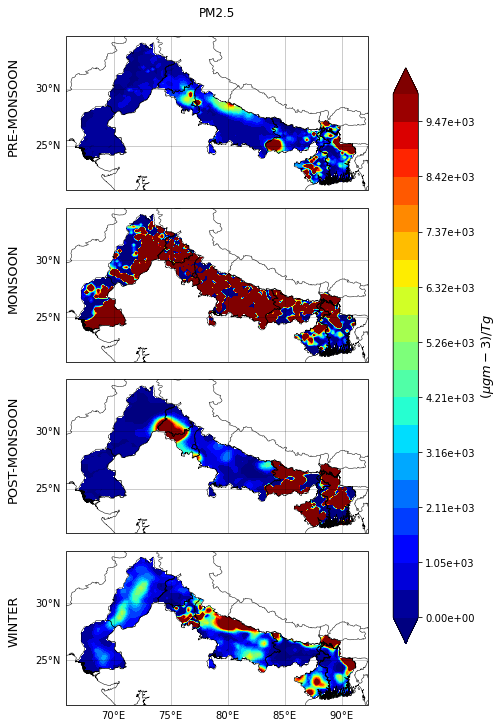

In [57]:
#Plot
lon =spm25["aut"][0].XLONG[:, :]
lat =spm25["aut"][0].XLAT[:, :]

savepth="/exports/csce/datastore/geos/users/s1878599/"
sensplot(lat,lon,spm25["pmon"][0].sty,spm25["mon"][0].sty,spm25["aut"][0].sty,spm25["win"][0].sty,cmap="jet",vmin=0,vmax=1e4,label="$(\mu g m-3)/Tg$",title="PM2.5",
        levs=20,format="%.2e",figsize=[7,10]) #,save=True, spath=savepth,name="sens_pm25",savef='pdf', dpi=300 label="$(\mu g m-3)$")

0 10000.0
[    0.           526.31578947  1052.63157895  1578.94736842
  2105.26315789  2631.57894737  3157.89473684  3684.21052632
  4210.52631579  4736.84210526  5263.15789474  5789.47368421
  6315.78947368  6842.10526316  7368.42105263  7894.73684211
  8421.05263158  8947.36842105  9473.68421053 10000.        ]


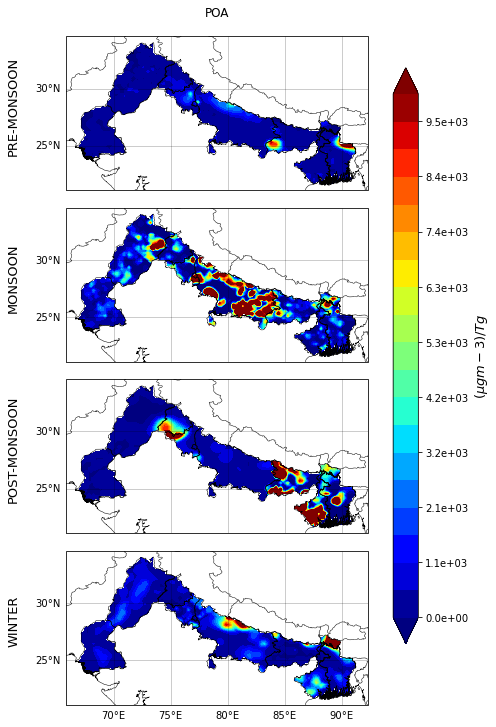

In [58]:

savepth="/exports/csce/datastore/geos/users/s1878599/"
sensplot(lat,lon,sPOA["pmon"][0].sty,sPOA["mon"][0].sty,sPOA["aut"][0].sty,sPOA["win"][0].sty,cmap="jet",vmin=0,vmax=1e4, label='$(\mu g m-3)/Tg$',title="POA",
        levs=20,format="%.1e",figsize=[7,10]) #,save=True, spath=savepth,name="sens_pm25",savef='pdf', dpi=100)

0 10000.0
[    0.           526.31578947  1052.63157895  1578.94736842
  2105.26315789  2631.57894737  3157.89473684  3684.21052632
  4210.52631579  4736.84210526  5263.15789474  5789.47368421
  6315.78947368  6842.10526316  7368.42105263  7894.73684211
  8421.05263158  8947.36842105  9473.68421053 10000.        ]


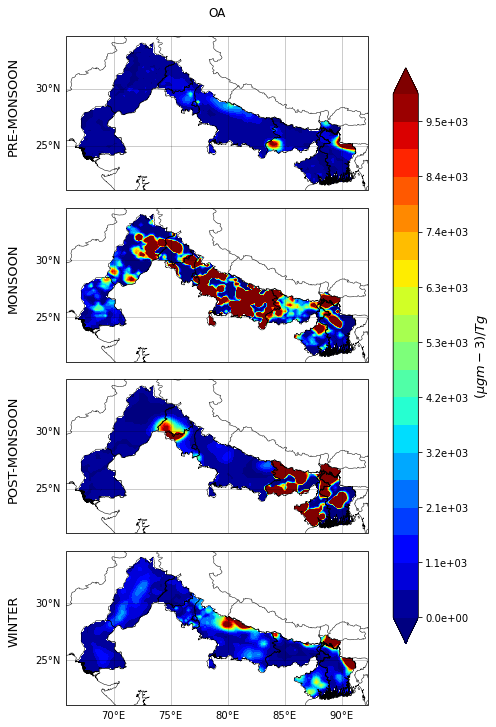

In [59]:
#Plot

savepth="/exports/csce/datastore/geos/users/s1878599/"
sensplot(lat,lon,sOA["pmon"][0].sty,sOA["mon"][0].sty,sOA["aut"][0].sty,sOA["win"][0].sty,cmap="jet" ,vmin=0,vmax=1e4, label="$(\mu g m-3)/Tg$",title="OA",
        levs=20,format="%.1e",figsize=[7,10]) #,save=True, spath=savepth,name="sens_pm25",savef='pdf', dpi=100)

In [60]:
#Plot
savepth="/exports/csce/datastore/geos/users/s1878599/"
sensplot(lat,lon,sSOA["pmon"][0].sty,sSOA["mon"][0].sty,sSOA["aut"][0].sty,sSOA["win"][0].sty,cmap="jet",vmin=0vmax=1e4, label='$(\mu g m-3)/ Tg$',title="SOA",
        levs=20,format="%.1e",figsize=[7,10]) #,save=True, spath=savepth,name="sens_pm25",savef='pdf', dpi=100)

SyntaxError: invalid syntax (<ipython-input-60-4e90934a613e>, line 3)